In [31]:
# assuming that you've previously run: 
# pip install fairlearn==0.4.6

import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from fairlearn.postprocessing import ThresholdOptimizer

# fetch data from OpenML
data = fetch_openml(data_id=42193)
X = pd.DataFrame(data['data'], columns=data['feature_names']).drop(columns=['race_Caucasian', 'c_charge_degree_F'])
y = data['target'].astype(np.int)

# Train a simple logistic regression model
lr = LogisticRegression(max_iter=1000)
lr.fit(X, y)

# Train threshold optimizer
race = pd.Series(X['race_African-American']).map(lambda row: "African American" if row == 1.0 else "Caucasian")
to = ThresholdOptimizer(estimator=lr, constraints='equalized_odds', grid_size=1000)
to.fit(X, y, sensitive_features=race)

ThresholdOptimizer(constraints='equalized_odds',
                   estimator=LogisticRegression(max_iter=1000))

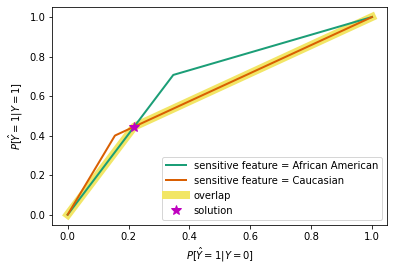

In [32]:
from fairlearn.postprocessing._plotting import plot_threshold_optimizer

plot_threshold_optimizer(to)

In this example 1 means predicted to reoffend and 0 means not predicted to reoffend. To be clear, I don't endorse using the COMPAS dataset, but it was the first dataset I had readily available.

For sensitive features we just have race with values African American and Caucasian. There are a few more in the dataset, but with very few rows. One of the issues with Threshold Optimizer is that it doesn't deal well with small groups since they have odd ROC curves and it needs to take the overlap. Overlaps of weird curves mean you get a weird overlap that isn't very useful. So always make sure that the size of each group is sufficiently large.

You've probably guessed that this is strange! There are only the extreme points (0,0) and (1,1) as well as 1 extra point in the middle for each group! That's because we passed a binary classifier, so all scores are 0 or 1. Let's make it use `predict_proba` next to get more scores between 0 and 1.

In [3]:
from sklearn.base import BaseEstimator, ClassifierMixin

class LogisticRegressionProba(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.log_reg_ = LogisticRegression(max_iter=1000)
    
    def fit(self, X, y, sample_weight=None):
        self.log_reg_.fit(X, y, sample_weight=sample_weight)
    
    def predict(self, X):
        return self.log_reg_.predict_proba(X)[:, 1]


In [34]:
lrp = LogisticRegressionProba()
lrp.fit(X, y)

# Train threshold optimizer
top = ThresholdOptimizer(estimator=lrp, constraints='equalized_odds', grid_size=1000, prefit=False)
top.fit(X, y, sensitive_features=race)

ThresholdOptimizer(constraints='equalized_odds',
                   estimator=LogisticRegressionProba())

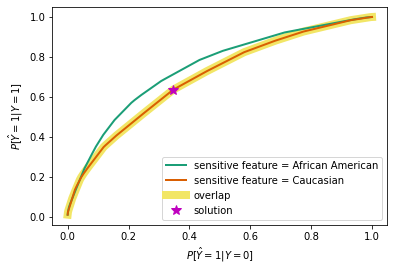

In [35]:
plot_threshold_optimizer(top)

Very interesting! You can see that the curve has many more points this time, but in the area where the best solution is found one of the curves is strictly below the other. Let's look at the thresholding rules!

In [36]:
top.interpolated_thresholder_.interpolation_dict

{'African American': {'p_ignore': 0.2098275659612656,
  'prediction_constant': 0.34600000000000003,
  'p0': 0.6964999999999997,
  'operation0': [>0.5122959210368792],
  'p1': 0.3035000000000003,
  'operation1': [>0.46169063083016226]},
 'Caucasian': {'p_ignore': 0.0,
  'prediction_constant': 0.34600000000000003,
  'p0': 0.998274809160305,
  'operation0': [>0.3887807256236323],
  'p1': 0.0017251908396950233,
  'operation1': [>0.3456151493387448]}}

As expected, we have two entries - one for each group! The formula used is

```p_ignore * prediction_constant + (1-p_ignore) * (p0 * operation0(score) + p1 * operation1(score))```

The African American curve is stricly above the Caucasian curve at the solution point, and that's why it needs to be adjusted towards the diagonal through adding randomization. That's the `p_ignore` part. For Caucasian that's 0 so the entire first term is 0.

Let's think about what this means for a second.

African American:
- always `0.147... * 0.342 ~ 0.05`, i.e. 5% chance of getting label 1 regardless of any features. That's obviously unacceptable in a criminal justice application context!
- The remaining part of the probability is decided by two thresholds, i.e. `(1-p_ignore) ~ 0.85` or 85%. If the score is above 0.47 that adds 0.238... and if it's above 0.518 that adds the remaining 0.761. Both of those last numbers would have to be multiplied by 85% to get the true amount they add since `p_ignore` is non-zero here. So that part is at least somewhat sensible. It looks like there's some sort of step function with these two thresholds determining the outcome.

Caucasian:
- no baseline probability for getting label 1. That is definitely good, but since it's not true for African Americans on the whole the solution doesn't make sense.
- Due to `p_ignore=0` the formula reduces to `p0 * operation0(score) + p1 * operation1(score)`. Since p1 is basically 1 this could be simplified to the simple thresholding rule "if `>0.38` then label 1 else label 0".


What to do?
- use a different method such as ExponentiatedGradient or GridSearch
- make it deterministic and eliminate the undesirable parts: in the thresholding rules for African American we only add randomization to get below the ROC curve, i.e. we're willingly making the solution worse. Depending on your application context you may be fine with having it work slightly better for one group in favor of adding randomness. You could just override `p_ignore` to be zero. With that you're still not at a deterministic solution, though, because scores between the two thresholds would result in a probability of 0.23 of getting label 1. Since the thresholds are so close to each other, perhaps it's acceptable to reduce it to a single threshold somewhere in the middle, perhaps at 0.5? Regardless of the chosen solution, note that this is very much risky in terms of disparate treatment. We're explicitly setting different thresholds per group which sounds to me like the textbook definition of disparate treatment (but then I'm not a lawyer so don't treat this as legal advice).

In [42]:
from fairlearn.reductions import ExponentiatedGradient, GridSearch, EqualizedOdds

expgrad = ExponentiatedGradient(estimator=lrp, constraints=EqualizedOdds(), eps=0.1)
expgrad.fit(X, y, sensitive_features=race)

gs = GridSearch(estimator=lrp, constraints=EqualizedOdds(), grid_size=50)  # the higher the grid size the more likely we are to find a good solution
gs.fit(X, y, sensitive_features=race)

In [43]:
from fairlearn.metrics import mean_prediction_group_summary, equalized_odds_difference

# looking at mean prediction for a second since that's the floating point substitute of selection rate.
# That's not what we optimized for (we used Equalized Odds), so the disparities are expected. 

top_mean_pred = top._pmf_predict(X, sensitive_features=race)[:, 1]

# ExponentiatedGradient arrives at a solutions that consists of many estimators
# that are weighted, aggregates their 0/1 predictions according to their weights
# and uses that as a probability. We shouldn't use the predict functionality to
# evaluate fairness since it wouldn't be reproducible. Instead I'm using the
# probabilistic mass function and will take that as a mean prediction.
expgrad_mean_pred = expgrad._pmf_predict(X)[:, 1]


# GridSearch just calls the best estimator that it found while searching the grid,
gs_mean_pred = gs.predict(X)

print(mean_prediction_group_summary(y, top_mean_pred, sensitive_features=race))
print(mean_prediction_group_summary(y, expgrad_mean_pred, sensitive_features=race))
print(mean_prediction_group_summary(y, gs_mean_pred, sensitive_features=race))


{'overall': 0.48204539964095955, 'by_group': {'African American': 0.49728728527728133, 'Caucasian': 0.4590339936041932}}
{'overall': 0.4711397005636514, 'by_group': {'African American': 0.4774557528813684, 'Caucasian': 0.46160405334122895}}
{'overall': 0.495796077299739, 'by_group': {'African American': 0.4763834535561301, 'Caucasian': 0.5251042467652446}}


I'd love to look at False Positive and True Positive Rates at this point because that's what Equalized Odds optimizes for. However, I can't do that because we have probabilities, i.e. floating point numbers, as opposed to 0/1. Instead, I'll use over/underprediction which is quite similar but works for floats.

In [44]:
from fairlearn.metrics import _mean_overprediction_group_summary, _mean_underprediction_group_summary
print("overprediction")
print(_mean_overprediction_group_summary(y, top_mean_pred, sensitive_features=race))
print(_mean_overprediction_group_summary(y, expgrad_mean_pred, sensitive_features=race))
print(_mean_overprediction_group_summary(y, gs_mean_pred, sensitive_features=race))
print("underprediction")
print(_mean_underprediction_group_summary(y, top_mean_pred, sensitive_features=race))
print(_mean_underprediction_group_summary(y, expgrad_mean_pred, sensitive_features=race))
print(_mean_underprediction_group_summary(y, gs_mean_pred, sensitive_features=race))

overprediction
{'overall': 0.18322660098522178, 'by_group': {'African American': 0.16499023622047262, 'Caucasian': 0.21075891583452216}}
{'overall': 0.21472008094282485, 'by_group': {'African American': 0.18971911074884093, 'Caucasian': 0.25246524516816915}}
{'overall': 0.2386512110460249, 'by_group': {'African American': 0.19759196980470745, 'Caucasian': 0.30064031753255965}}
underprediction
{'overall': 0.17162455109795563, 'by_group': {'African American': 0.19085255724240235, 'Caucasian': 0.14259510767968694}}
{'overall': 0.21402373013286857, 'by_group': {'African American': 0.23541296416668508, 'Caucasian': 0.18173137727629818}}
{'overall': 0.21329848349998046, 'by_group': {'African American': 0.24435812254778994, 'Caucasian': 0.16640625621667318}}


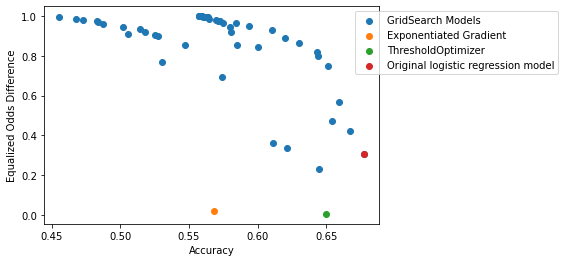

In [45]:
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from fairlearn.metrics import equalized_odds_difference

# Plot equalized odds difference vs accuracy
accuracy_gs = [accuracy_score(y, pd.Series(gsm.predict(X)).map(lambda row: 1 if row > 0.5 else 0)) for gsm in gs.predictors_]
equalized_odds_sweep_gs = [equalized_odds_difference(y, pd.Series(gsm.predict(X)).map(lambda row: 1 if row > 0.5 else 0), sensitive_features=race) for gsm in gs.predictors_]
plt.scatter(accuracy_gs, equalized_odds_sweep_gs, label="GridSearch Models")
plt.scatter(accuracy_score(y, expgrad.predict(X)),
            equalized_odds_difference(y, expgrad.predict(X), sensitive_features=race), 
            label="Exponentiated Gradient")
plt.scatter(accuracy_score(y, top.predict(X, sensitive_features=race)), 
            equalized_odds_difference(y, top.predict(X, sensitive_features=race), sensitive_features=race),
            label="ThresholdOptimizer")
plt.scatter(accuracy_score(y, lr.predict(X)),
            equalized_odds_difference(y, lr.predict(X), sensitive_features=race), 
            label="Original logistic regression model")
plt.xlabel("Accuracy")
plt.ylabel("Equalized Odds Difference")
plt.legend(bbox_to_anchor=(1.55, 1))
plt.show()

Turns out in this case ThresholdOptimizer is much better than GridSearch or ExponentiatedGradient! In fact, it's worth considering whether we're willing to give up the accuracy between the logistic regression model and the threshold optimizer solution for the disparity difference. 0.3 is quite a bit, though, if you consider that it would violate the 4/5ths rule. If we use different underlying estimators (other than logistic regression) it's entirely possible that the results will look very different, too.